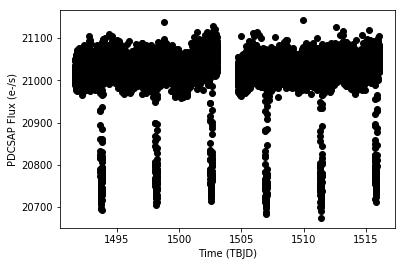

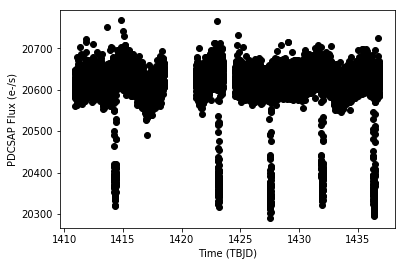

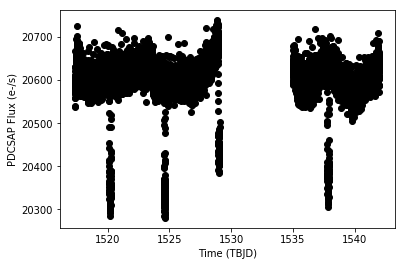

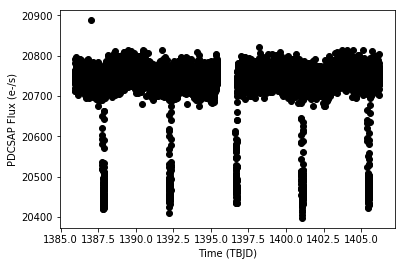

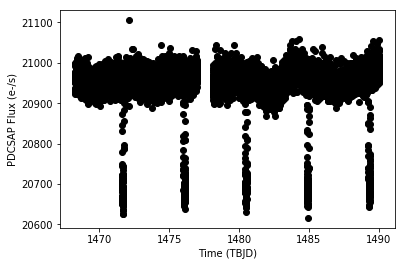

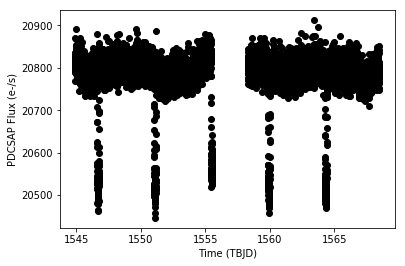

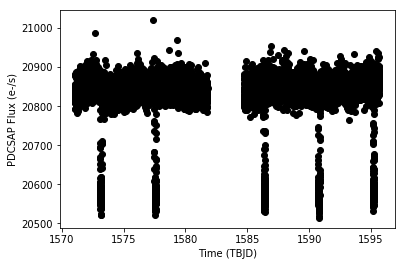

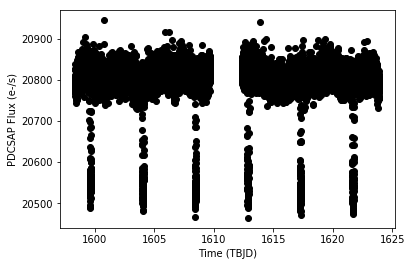

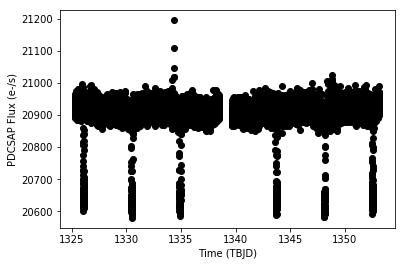

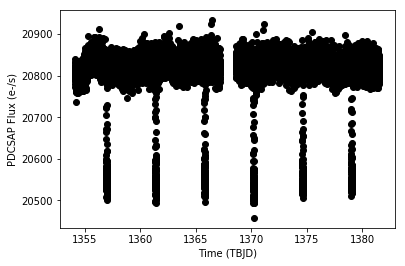

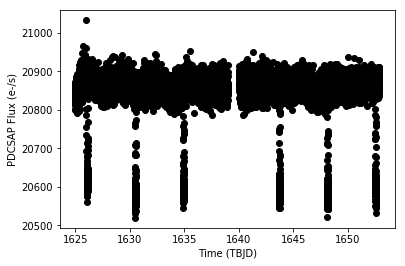

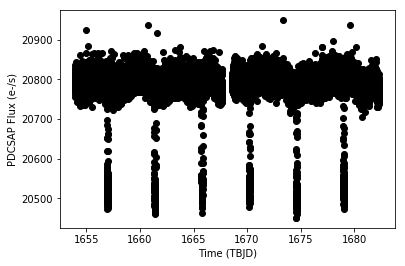

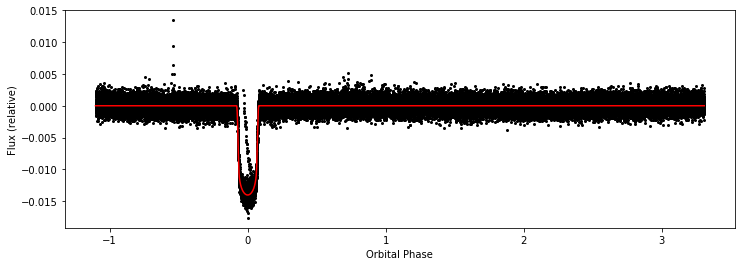

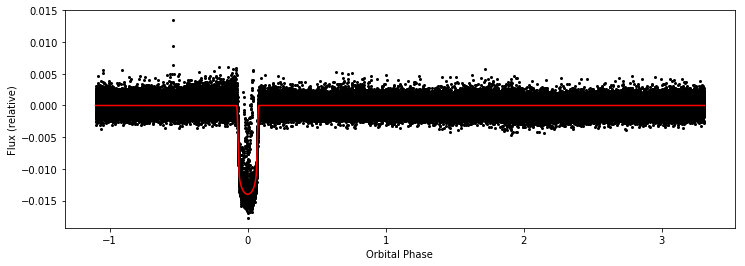

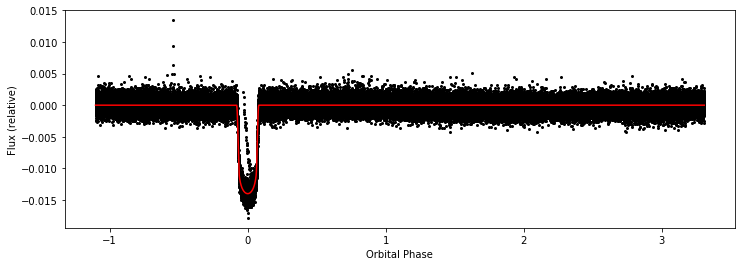

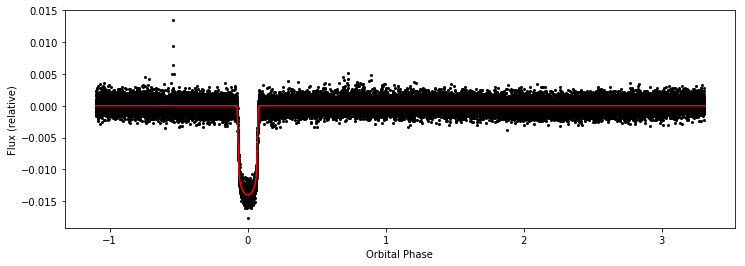

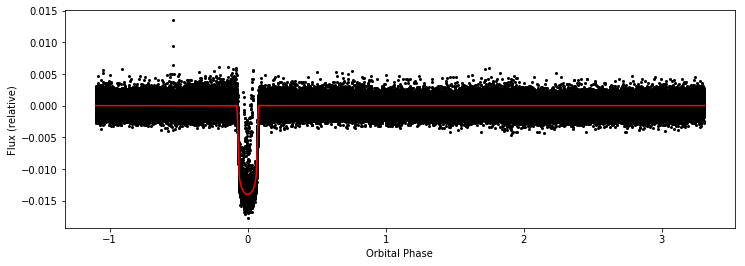

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from astropy.io import fits

dataproducts = pd.read_csv('dataproducts_example.csv')

engine = create_engine('sqlite://', echo=False)

dataproducts.to_sql('dataproducts', con=engine)

def get_urls(tic_id):
    urls = engine.execute("SELECT dataURL FROM dataproducts WHERE TIC_ID =" +
                          str(tic_id)).fetchall()
    urls = [url[0] for url in urls]
    return urls

def get_lcs(urls):
    return [url for url in urls if url.endswith('lc.fits')]

def get_dvts(urls):
    return [url for url in urls if url.endswith('dvt.fits')]

def plot_lc(lc):
    fits_file = ('https://mast.stsci.edu/api/v0.1/Download/file?uri=' + lc)
            
    with fits.open(fits_file, mode="readonly") as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    
    fig, ax = plt.subplots()

    ax.plot(tess_bjds, pdcsap_fluxes, 'ko')

    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    return ax

def plot_dvt(dvt):
    fits_file = ('https://mast.stsci.edu/api/v0.1/Download/file?uri=' + dvt)
    
    with fits.open(fits_file, mode="readonly") as hdulist:

        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']

        period = hdulist[1].header['TPERIOD']
        duration = hdulist[1].header['TDUR']
        epoch = hdulist[1].header['TEPOCH']
        depth = hdulist[1].header['TDEPTH']

        times = hdulist[1].data['TIME']
        phases = hdulist[1].data['PHASE']
        fluxes_init = hdulist[1].data['LC_INIT']
        model_fluxes_init = hdulist[1].data['MODEL_INIT']
    
    sort_indexes = np.argsort(phases)

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(phases[sort_indexes], fluxes_init[sort_indexes], 'ko',
           markersize=2)

    ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

    ax.set_ylabel("Flux (relative)")
    ax.set_xlabel("Orbital Phase")

    return ax

def save_all_lcs(tic_id):
    count = 0
    for lc in get_lcs(get_urls(tic_id)):
        plot_lc(lc)
        plt.savefig(fname=(str(tic_id) + '_lc_' + str(count)))
        count += 1

def save_all_dvts(tic_id):
    count = 0
    for dvt in get_dvts(get_urls(tic_id)):
        plot_dvt(dvt)
        plt.savefig(fname=(str(tic_id) + '_dvt_' + str(count)))
        count += 1
        
# This TIC has lcs:
save_all_lcs(149603524)

# This TIC does not:
save_all_lcs(149603523)

# This TIC has dvts:
save_all_dvts(149603524)

# This TIC does not:
save_all_dvts(149603523)